# Trabalho Prático I - Classificação de Exoplanetas

- Disciplina: Aprendizado de Máquinas
- Aluno: Vítor Gabriel Reis Caitité
- Matrícula: 2021712430

## Objetivo:

O objetivo deste trabalho prático é de praticar os conceitos aprendidos na disciplina Aprendizado de Máquinas e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Para isso serão utilizados e comparados métodos de classificação baseados em princı́pios diferentes em um problema de classificação binária de candidatos a exoplanetas.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
import seaborn as sns
import tabulate

## Leitura e Pré-processamento dos Dados 

In [2]:
df = pd.read_csv('koi_data.csv')
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [3]:
X = df.drop(["kepoi_name", "koi_disposition"], axis='columns').to_numpy()
y = df["koi_disposition"].to_numpy()
y[y == "CONFIRMED"] = 1
y[y == "FALSE POSITIVE"] = 0
y = np.array(y.tolist())

## Naive Bayes

In [4]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [5]:
def plot_roc_curve(tprs):
    plt.figure(figsize=(6,4))
    base_fpr = np.linspace(0, 1, 101)
    for tpr in tprs:
        plt.plot(base_fpr, tpr, 'b', alpha=0.15)
    # Mean and Std 
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # Plot mean ROC curve and also the variance around it to build confidence intervals
    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.show()

Accuracy (fold 1): 0.9193
Accuracy (fold 2): 0.9049
Accuracy (fold 3): 0.9221
Accuracy (fold 4): 0.9183
Accuracy (fold 5): 0.9231

Mean Accuracy: 0.9175+/-0.0066
Mean Precision: 0.8459+/-0.0132
Mean Recall: 0.9727+/-0.0070


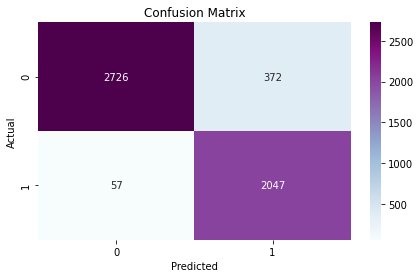

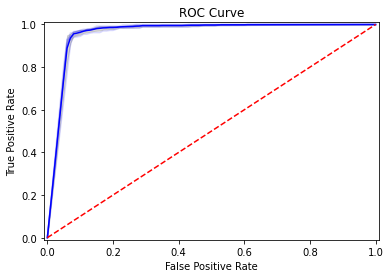

In [6]:
def apply_cross_validation(model, params={}):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    predicted_classes = []
    pred_proba = []
    real_classes = []
    accuracy = np.zeros(5)
    precision = np.zeros(5)
    recall = np.zeros(5)
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    idx = 0
    for train_indices, test_indices in k_fold.split(X, y):
        normalizer = MinMaxScaler()
        X_train = normalizer.fit_transform(X[train_indices])
        X_test = normalizer.transform(X[test_indices])
        y_train = y[train_indices]
        y_test = y[test_indices]

        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        #calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        y_score = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        pred_proba = np.append(pred_proba, y_score[:, 1])
        idx +=1
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred)))  
    mean_accuracy = '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())
    mean_precision ='{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())
    mean_recall = '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std())
    print(f"\nMean Accuracy: " + mean_accuracy) 
    print(f"Mean Precision: " + mean_precision) 
    print(f"Mean Recall: " + mean_recall) 
    plot_confusion_matrix(real_classes, predicted_classes, [0, 1])
    plot_roc_curve(np.array(tprs))
    pr_curve = precision_recall_curve(real_classes, pred_proba)
    return clf, mean_accuracy, mean_precision, mean_recall, np.array(tprs), pr_curve

model = GaussianNB
clf, mean_accuracy_nb, mean_precision_nb, mean_recall_nb, roc_nb, pr_nb = apply_cross_validation(model)

## Decision Tree

In [7]:
lst = list(range(1,11))
lst.append(None)
# Grid Search application
grid_params_DecisionTree = [{'DecisionTreeClassifier__max_depth': lst}]
pipe_tree = Pipeline([('scaler',  MinMaxScaler()),
            ('DecisionTreeClassifier', DecisionTreeClassifier())])
clf = GridSearchCV(pipe_tree, grid_params_DecisionTree , scoring='accuracy', refit=True, cv=5, verbose=3)
# Run fit with all sets of parameters.
clf.fit(X, y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END DecisionTreeClassifier__max_depth=1;, score=0.809 total time=   0.0s
[CV 2/5] END DecisionTreeClassifier__max_depth=1;, score=0.766 total time=   0.0s
[CV 3/5] END DecisionTreeClassifier__max_depth=1;, score=0.759 total time=   0.0s
[CV 4/5] END DecisionTreeClassifier__max_depth=1;, score=0.600 total time=   0.0s
[CV 5/5] END DecisionTreeClassifier__max_depth=1;, score=0.688 total time=   0.0s
[CV 1/5] END DecisionTreeClassifier__max_depth=2;, score=0.819 total time=   0.1s
[CV 2/5] END DecisionTreeClassifier__max_depth=2;, score=0.824 total time=   0.1s
[CV 3/5] END DecisionTreeClassifier__max_depth=2;, score=0.932 total time=   0.1s
[CV 4/5] END DecisionTreeClassifier__max_depth=2;, score=0.912 total time=   0.0s
[CV 5/5] END DecisionTreeClassifier__max_depth=2;, score=0.841 total time=   0.0s
[CV 1/5] END DecisionTreeClassifier__max_depth=3;, score=0.917 total time=   0.1s
[CV 2/5] END DecisionTreeClassifier__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'DecisionTreeClassifier__max_depth': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                None]}],
             scoring='accuracy', verbose=3)

In [8]:
max_depth = clf.best_params_['DecisionTreeClassifier__max_depth']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for max_depth = " + str(max_depth) )

The best mean accuracy was 0.9475 and was achieved for max_depth = 6


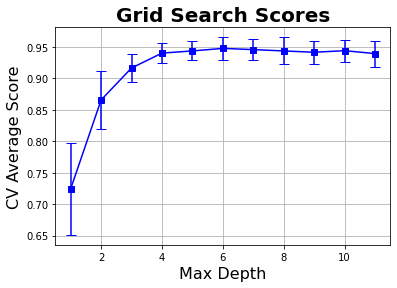

In [9]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    ax.errorbar(grid_param_1, scores_mean, scores_sd, color = 'blue', marker='s', capsize=5)

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    
# Calling Method 
lst = list(range(1,12))
plot_grid_search(clf.cv_results_, lst, 'Max Depth')

Accuracy (fold 1): 0.9472
Accuracy (fold 2): 0.9452
Accuracy (fold 3): 0.9481
Accuracy (fold 4): 0.9596
Accuracy (fold 5): 0.9510

Mean Accuracy: 0.9502+/-0.0050
Mean Precision: 0.9212+/-0.0107
Mean Recall: 0.9586+/-0.0067


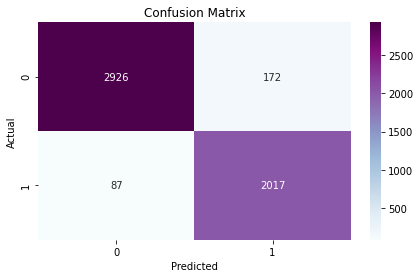

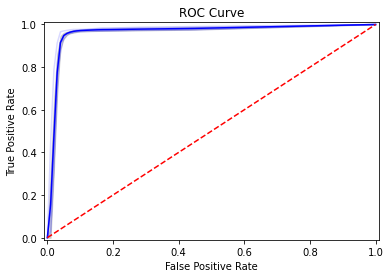

In [10]:
model = DecisionTreeClassifier
params = {'max_depth' : max_depth}
clf, mean_accuracy_dt, mean_precision_dt, mean_recall_dt, roc_dt, pr_dt = apply_cross_validation(model, params)

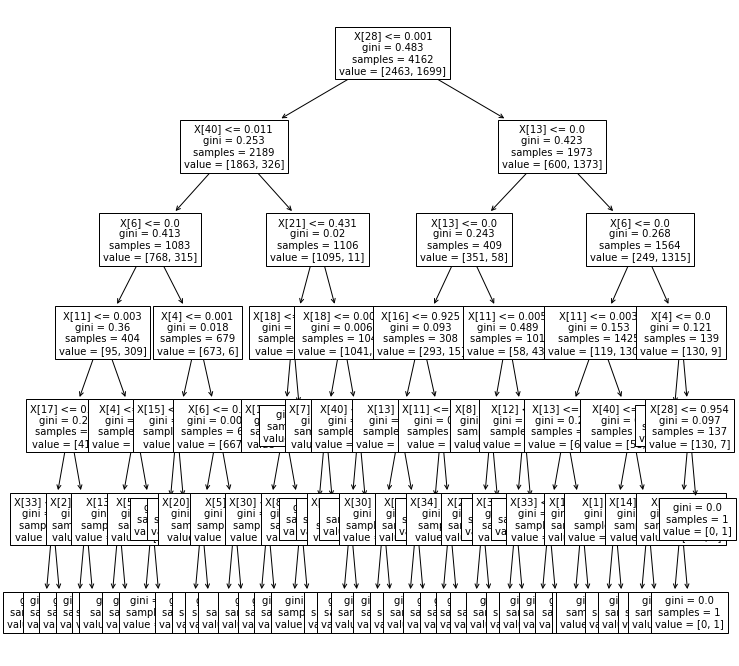

In [11]:
# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

## SVM

### SVM Kernel Linear

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9441 and was achieved for C = 100.0


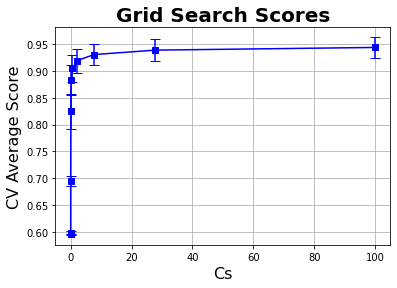

In [12]:
lst = np.logspace(-3, 2, 10)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="linear"))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
#Results of Grid Seach:
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.9443
Accuracy (fold 2): 0.9472
Accuracy (fold 3): 0.9433
Accuracy (fold 4): 0.9442
Accuracy (fold 5): 0.9538

Mean Accuracy: 0.9466+/-0.0039
Mean Precision: 0.9124+/-0.0078
Mean Recall: 0.9602+/-0.0048


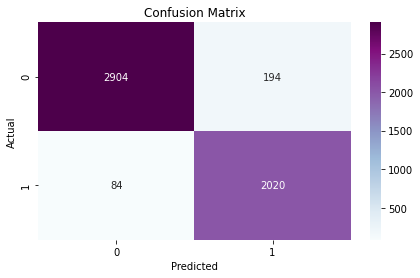

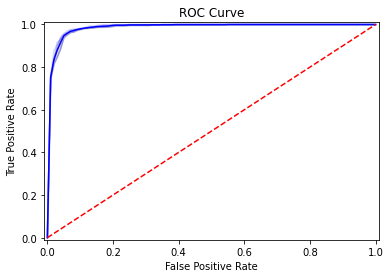

In [13]:
model = svm.SVC
params = {'kernel' : "linear", 'C' : C, 'probability' : True}
clf, mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm, roc_linear_svm, pr_lsvm = apply_cross_validation(model, params)

### SVM Kernel Sigmoid

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.6388 and was achieved for C = 2.1544346900318843


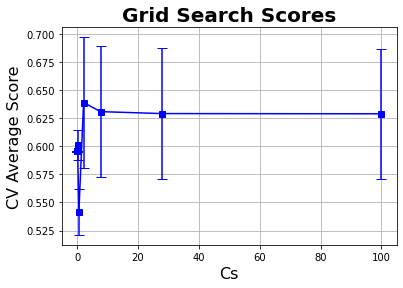

In [14]:
lst = np.logspace(-3, 2, 10)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="sigmoid", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.6647
Accuracy (fold 2): 0.6551
Accuracy (fold 3): 0.6663
Accuracy (fold 4): 0.6548
Accuracy (fold 5): 0.6577

Mean Accuracy: 0.6597+/-0.0049
Mean Precision: 0.5793+/-0.0286
Mean Recall: 0.5881+/-0.0330


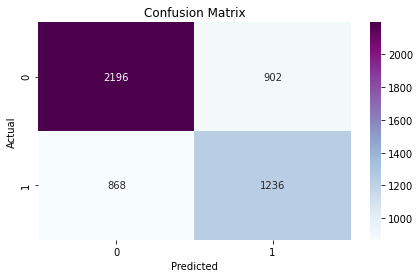

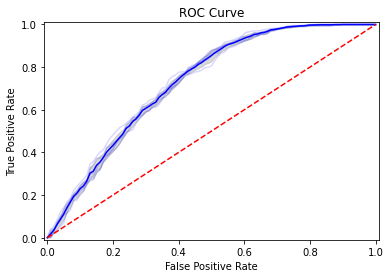

In [15]:
model = svm.SVC
params = {'kernel' : "sigmoid", 'gamma' : 'scale', 'C' : C, 'probability' : True}
clf, mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm, roc_sigmoid_svm, pr_ssvm= apply_cross_validation(model, params)

### SVM Kernel Polinomial

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9448 and was achieved for C = 100.0


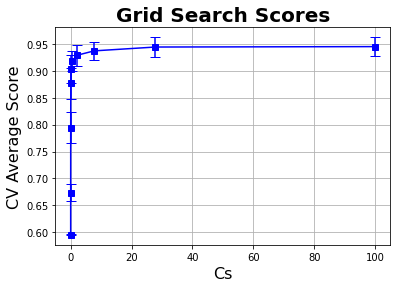

In [16]:
lst = np.logspace(-3, 2, 10)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="poly", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.9472
Accuracy (fold 2): 0.9472
Accuracy (fold 3): 0.9481
Accuracy (fold 4): 0.9500
Accuracy (fold 5): 0.9471

Mean Accuracy: 0.9479+/-0.0011
Mean Precision: 0.9166+/-0.0062
Mean Recall: 0.9581+/-0.0067


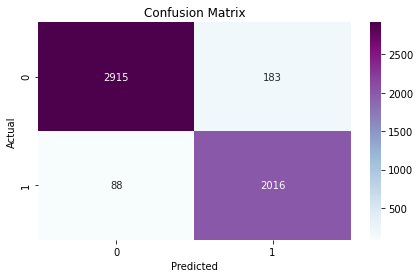

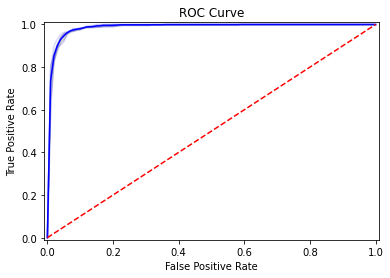

In [17]:
model = svm.SVC
params = {'kernel' : "poly", 'gamma' : 'scale', 'C' : C, 'probability' : True}
clf, mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm, roc_poly_svm, pr_psvm = apply_cross_validation(model, params)

### SVM Kernel RBF

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9371 and was achieved for C = 100.0


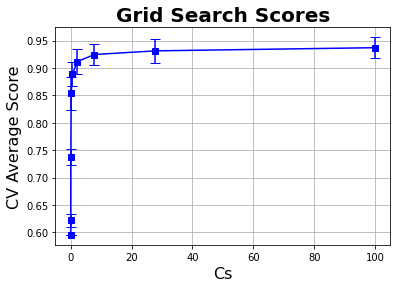

In [18]:
lst = np.logspace(-3, 2, 10)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="rbf", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.9414
Accuracy (fold 2): 0.9414
Accuracy (fold 3): 0.9365
Accuracy (fold 4): 0.9433
Accuracy (fold 5): 0.9481

Mean Accuracy: 0.9421+/-0.0037
Mean Precision: 0.9022+/-0.0095
Mean Recall: 0.9612+/-0.0039


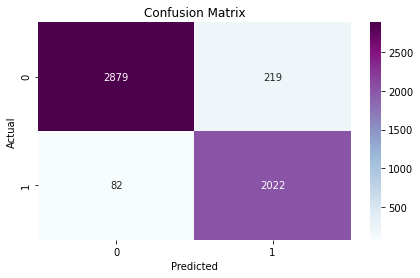

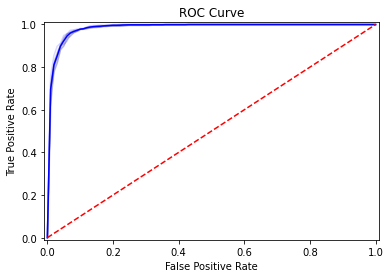

In [19]:
model = svm.SVC
params = {'kernel' : "rbf", 'gamma' : 'scale', 'C': C, 'probability' : True}
clf, mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm, roc_rbf_svm, pr_rsvm = apply_cross_validation(model, params)

In [20]:
data = [["SVM Kernel", 'Accuracy', 'Precision', 'Recall'],
        ["Linear", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["Sigmoid", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["Poly", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["RBF", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------+-----------------+-----------------+-----------------+
| SVM Kernel | Accuracy        | Precision       | Recall          |
+------------+-----------------+-----------------+-----------------+
| Linear     | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------+-----------------+-----------------+-----------------+
| Sigmoid    | 0.6597+/-0.0049 | 0.5793+/-0.0286 | 0.5881+/-0.0330 |
+------------+-----------------+-----------------+-----------------+
| Poly       | 0.9479+/-0.0011 | 0.9166+/-0.0062 | 0.9581+/-0.0067 |
+------------+-----------------+-----------------+-----------------+
| RBF        | 0.9421+/-0.0037 | 0.9022+/-0.0095 | 0.9612+/-0.0039 |
+------------+-----------------+-----------------+-----------------+


## k-NN

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best mean accuracy was 0.8422 and was achieved for K = 8


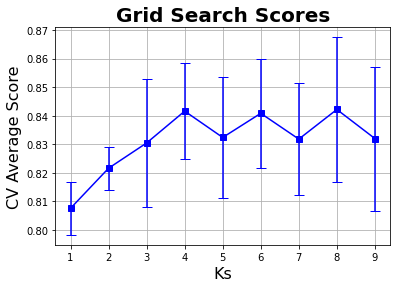

In [21]:
lst =  list(range(1,10))
# Grid Search application
grid_params_knn = [{'knn__n_neighbors': lst}]
pipe_knn = Pipeline([('scaler',  MinMaxScaler()),
            ('knn', KNeighborsClassifier())])
clf = GridSearchCV(pipe_knn, grid_params_knn , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
k  = clf.best_params_['knn__n_neighbors']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for K = " + str(k) )
plot_grid_search(clf.cv_results_, lst, 'Ks')

Accuracy (fold 1): 0.8521
Accuracy (fold 2): 0.8434
Accuracy (fold 3): 0.8606
Accuracy (fold 4): 0.8375
Accuracy (fold 5): 0.8404

Mean Accuracy: 0.8468+/-0.0084
Mean Precision: 0.7596+/-0.0237
Mean Recall: 0.9097+/-0.0223


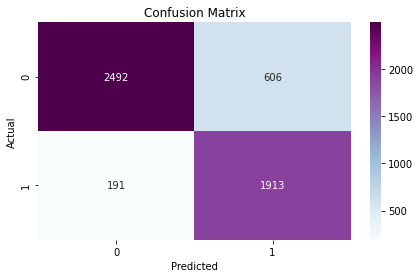

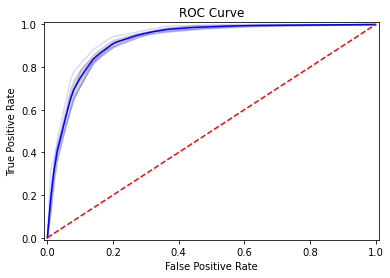

In [22]:
model = KNeighborsClassifier
params = {'n_neighbors' : k}
clf, mean_accuracy_knn, mean_precision_knn, mean_recall_knn, roc_knn, pr_knn = apply_cross_validation(model, params)

## Random Forest

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The best mean accuracy was 0.9619 and was achieved for n_estimators = 100


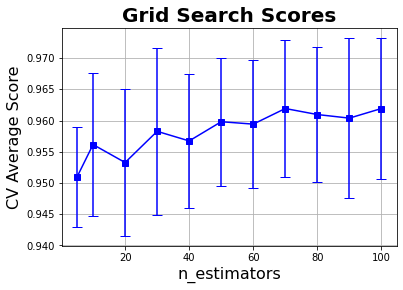

In [23]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_random_forest = [{'RandomForest__n_estimators': lst}]
pipe_random_forest = Pipeline([('scaler',  MinMaxScaler()),
            ('RandomForest', RandomForestClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_random_forest, grid_params_random_forest , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['RandomForest__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9606
Accuracy (fold 2): 0.9616
Accuracy (fold 3): 0.9596
Accuracy (fold 4): 0.9721
Accuracy (fold 5): 0.9673

Mean Accuracy: 0.9642+/-0.0048
Mean Precision: 0.9491+/-0.0097
Mean Recall: 0.9632+/-0.0066


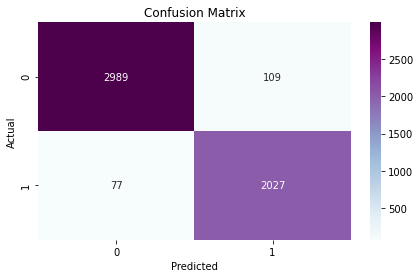

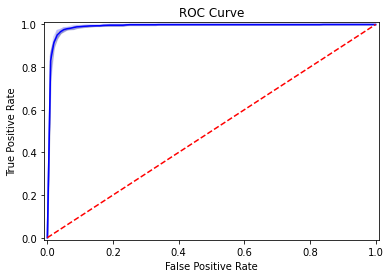

In [24]:
model = RandomForestClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_rf, mean_precision_rf, mean_recall_rf, roc_rf, pr_rf = apply_cross_validation(model, params)

## Gradient Tree Boosting

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The best mean accuracy was 0.9689 and was achieved for n_estimators = 90


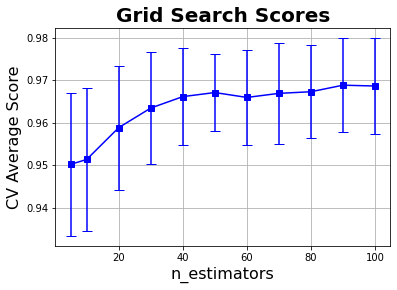

In [25]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'GradientBoosting__n_estimators': lst}]
pipe_gradient_boosting = Pipeline([('scaler',  MinMaxScaler()),
            ('GradientBoosting', GradientBoostingClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_gradient_boosting, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['GradientBoosting__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9750
Accuracy (fold 2): 0.9721
Accuracy (fold 3): 0.9683
Accuracy (fold 4): 0.9827
Accuracy (fold 5): 0.9731

Mean Accuracy: 0.9742+/-0.0048
Mean Precision: 0.9638+/-0.0078
Mean Recall: 0.9726+/-0.0107


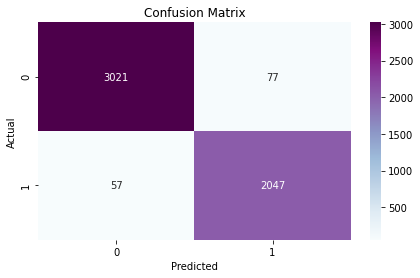

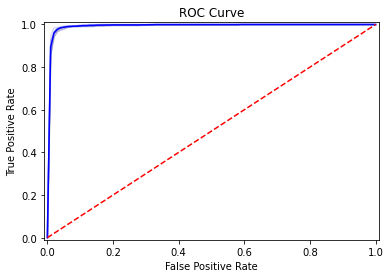

In [26]:
model = GradientBoostingClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_gb, mean_precision_gb, mean_recall_gb, roc_gb, pr_gb = apply_cross_validation(model, params)

## Comparação Entre os Métodos

### Accuracy, Precision and Recall

In [27]:
data = [["Método", 'Accuracy', 'Precision', 'Recall'],
        ["Naive Bayes", mean_accuracy_nb, mean_precision_nb, mean_recall_nb],
        ["Decision Tree", mean_accuracy_dt, mean_precision_dt, mean_recall_dt],
        ["SVM (Linear)", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["SVM (Sigmoid)", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["SVM (Poly)", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["SVM (RBF)", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm],
        ["k-NN", mean_accuracy_knn, mean_precision_knn, mean_recall_knn],
        ["Random Forest", mean_accuracy_rf, mean_precision_rf, mean_recall_rf],
        ["Gradient Tree Boosting", mean_accuracy_gb, mean_precision_gb, mean_recall_gb]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------------------+-----------------+-----------------+-----------------+
| Método                 | Accuracy        | Precision       | Recall          |
+------------------------+-----------------+-----------------+-----------------+
| Naive Bayes            | 0.9175+/-0.0066 | 0.8459+/-0.0132 | 0.9727+/-0.0070 |
+------------------------+-----------------+-----------------+-----------------+
| Decision Tree          | 0.9502+/-0.0050 | 0.9212+/-0.0107 | 0.9586+/-0.0067 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Linear)           | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Sigmoid)          | 0.6597+/-0.0049 | 0.5793+/-0.0286 | 0.5881+/-0.0330 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Poly)             | 0.9479+/-0.0011 | 0.9166+/-0.0062 | 0.9581+/-0.0067 |
+------------------------+--

### ROC Curve

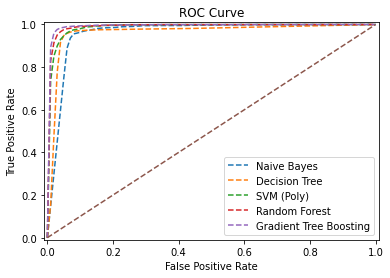

In [34]:
plt.figure(figsize=(6,4))
base_fpr = np.linspace(0, 1, 101)
# Plot mean ROC curve for all methods in the same graph
plt.plot(base_fpr, roc_nb.mean(axis=0), linestyle='--', label='Naive Bayes')
plt.plot(base_fpr, roc_dt.mean(axis=0), linestyle='--', label='Decision Tree')
#plt.plot(base_fpr, roc_linear_svm.mean(axis=0), linestyle='--', label='SVM (Linear)')
#plt.plot(base_fpr, roc_sigmoid_svm.mean(axis=0), linestyle='--', label='SVM (Sigmoid)')
#plt.plot(base_fpr, roc_rbf_svm.mean(axis=0), linestyle='--', label='SVM (RBF)')
plt.plot(base_fpr, roc_poly_svm.mean(axis=0), linestyle='--', label='SVM (Poly)')
plt.plot(base_fpr, roc_rf.mean(axis=0), linestyle='--', label='Random Forest')
plt.plot(base_fpr, roc_gb.mean(axis=0), linestyle='--', label='Gradient Tree Boosting')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.show()

### Precision-Recall Curve

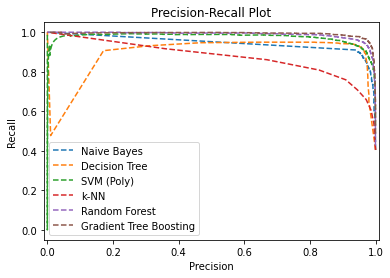

In [35]:
# Plot Precision-Recall curve for all methods in the same graph
plt.plot(pr_nb[1], pr_nb[0], linestyle='--', label='Naive Bayes')
plt.plot(pr_dt[1], pr_dt[0], linestyle='--', label='Decision Tree')
#plt.plot(pr_lsvm[1], pr_lsvm[0], linestyle='--', label='SVM (Linear)')
#plt.plot(pr_ssvm[1], pr_ssvm[0], linestyle='--', label='SVM (Sigmoid)')
#plt.plot(pr_rsvm[1], pr_rsvm[0], linestyle='--', label='SVM (RBF)')
plt.plot(pr_psvm[1], pr_psvm[0], linestyle='--', label='SVM (Poly)')
plt.plot(pr_knn[1], pr_knn[0], linestyle='--', label='k-NN')
plt.plot(pr_rf[1], pr_rf[0], linestyle='--', label='Random Forest')
plt.plot(pr_gb[1], pr_gb[0], linestyle='--', label='Gradient Tree Boosting')
plt.title('Precision-Recall Plot')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim([-0.01, 1.01])
plt.legend() 
plt.show()